<a name="init"></a>
<h1>Brain Tumor Classifier</h1>

#### Autor: [Juan Manuel Cornejo](https://www.linkedin.com/in/juanmanuelcornejociruelo/)

En este notebook encontrarás los modelos de CNN entrenados para la clasificación de MRI con o sin tummor, sin usar ImageDataGenerator en el proceso.

<dl>
  <dt><a href="#Librerias">1. Importar librerías</a></dt>
      <dd>Librerías usadas</dd>
    
  <dt><a href="#Constantes">2. Constantes usadas</a></dt>
      <dd>Tamaño de imagen , paths, epochs</dd>
    
  <dt><a href="#Funciones_visualizacion">3. Funciones de visualización</a></dt>
      <dd>Funciones de visualización usadas en el notebook</dd>
      <dd>3.1 Visualización imagen suelta</dd>
      <dd>3.2 Visualización para ver un conjunto de imágenes de ejemplo</dd>
      <dd>3.3 Visualización de errores del modelo</dd>
      <dd>3.4 Visualización historico entrenamiento</dd>
    
  <dt><a href="#Funcion_testeo">4. Función de test</a></dt>
      <dd>Función cpara verificar las predicciones</dd>
    
  <dt><a href="#Carga_verificacion">5. Carga y verificación dataframe</a></dt>
      <dd>Cargamos el dataframe creado en el notebook de normalización</dd>
      <dd>Tratamos sus datos para trabajar con el a continuación y los verificamos</dd>
    
  <dt><a href="#Split">6. Split de train, test y validation</a></dt>
      <dd>Separación del dataset para trabajar con train y validation. Guardamos unos pocos datos aleatorios apra verificar test</dd>
 
  <dt><a href="#Funcion_callback">7. Función de Earlystop y guardo</a></dt>
      <dd>Función para parar entrenamiento y guardar el mejor modelo</dd>
   
  <dt><a href="#VGG16">8. Modelo VVG16</a></dt>
      <dd>Modelo VGG16, entrenamiento, predicciones , matriz de confusión y verificación de resultados</dd>
    
  <dt><a href="#Inception_V3">9. Modelo Inception V3</a></dt>
      <dd>Modelo Inception_V3, entrenamiento, predicciones , matriz de confusión y verificación de resultados</dd>
    
   <dt><a href="#VGG19">10. Modelo VVG19</a></dt>
      <dd>Modelo VGG19, entrenamiento, predicciones , matriz de confusióny verificación de resultados</dd>
    
    <dt><a href="#Comparativa_pred">11. Comparativa predicciones</a></dt>
      <dd>Comparativa predicciones y visualización de fallos de cada modelo</dd>
    
</dl>

<a name="Librerias"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Importamos librerías
 * Vamos a importar algunos modelos preentrenados apra ver cual funciona mejor

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputVGG16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputInceptionV3
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_inputVGG19

<a name="Constantes"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Preparación de constantes

In [3]:
PATH = "/Users/jcornejo/Desktop/Brain Tumor ML/data/Brain_tumor_dataset_normalizado/"
PATH_MODEL ="/Users/jcornejo/Desktop/Brain Tumor ML/model/"

IMG_SIZE = 255
class_names = {'1' : 'Tumor', '0': 'Sano'}
BATCH_SIZE = 5
EPOCHS = 50

<a name="Funciones_visualizacion"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Funciones de visualización

In [3]:
def display_random_image(y_test, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(y_test[index])
    plt.show()

In [4]:
def display_examples(images, labels, cant_img):
    """
        Display cant_img images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(cant_img):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel([labels[i]])
    plt.show()

In [5]:
def print_mislabeled_images(X_test, y_test, prediction_rounded, cant_img):
    """
        Print cant_img examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (y_test == prediction_rounded)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = X_test[mislabeled_indices]
    mislabeled_labels = prediction_rounded[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(mislabeled_images, mislabeled_labels, cant_img)

In [6]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(25,8))

    # Plot accuracy5
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)


    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

<a name="Funcion_testeo"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Función de testeo

In [5]:
def pred_input(modelo, nombre_pred,IMG_SIZE, test_df):
    random = np.random.randint(1,len(test_df))
    img = image.load_img(PATH + (test_df.loc[random,"Filename"]), target_size=(IMG_SIZE, IMG_SIZE))
    
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = nombre_pred(img_batch)
    
    prediction = modelo.predict(img_preprocessed)
    
    print('Predicción:',prediction)
    plt.imshow(cv2.imread(PATH + (test_df.loc[random,"Filename"])))
    plt.title(test_df.loc[random,"Target"])
    plt.show();
# pred_input(model, preprocess_inputVGG19,IMG_SIZE, test_df)

<a name="Carga_verificacion"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# Cargamos el DF  que preparamos en el notebook de normalización
* Como recordatorio, en dicho notebook, buscamos el perímeto máximo de la imagen, quitando ruido, para así que todas las imagenens se centrasen en al resonancia y no otros datos como podía ser el numero de resonancia, hospital etc...
* Despúes de normalizar las imagenes según dicho patron, creamos un df , con el nombre de las imagenenes y su target ( Sin tumor = 0, Tumor = 1)
* Y verificamos que el Dataset está un poco desvalanceado.

In [4]:
df = pd.read_csv('../data/df_tumor.csv')
df.head()

,Filename,Target
0,yes.5_normalizada.jpg,1
1,no.51_normalizada.jpg,0
2,yes.53_normalizada.jpg,1
3,yes.136_normalizada.jpg,1
4,yes.14_normalizada.jpg,1


In [5]:
filenames_list = list(df['Filename'])

target_list = list(df['Target'])

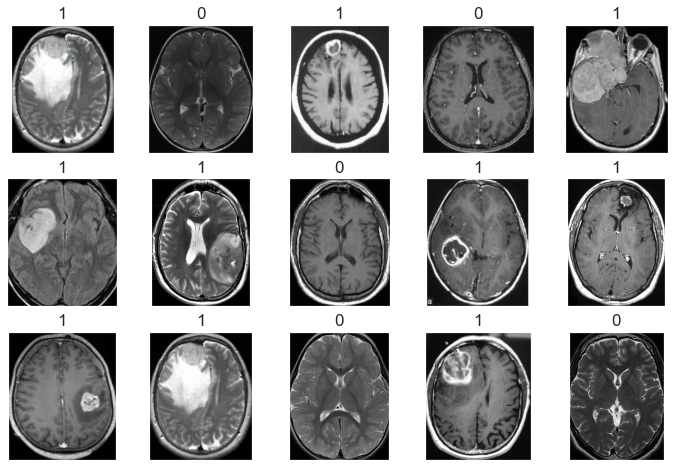

In [10]:
plt.figure(figsize=(12,8))

for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(PATH + (df.loc[random,"Filename"])))
    plt.xticks([])
    plt.yticks([])

    plt.title(df.loc[random,"Target"])

plt.show();

<a name="Split"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Creamos el split para test , train y validation

In [6]:
X = []
y = []
for file in filenames_list:
        
    img = imread(PATH + file)
    image_resized = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    X.append(image_resized)
    
X = np.array(X)
y = np.array(target_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(227, 255, 255, 3)
(227,)
(26, 255, 255, 3)
(26,)


In [7]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [8]:
X_train = X_train / 255.0
X_test = X_test /255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))
print("Min:", np.min(X_test))
print("Max:", np.max(X_test))

Min: 0.0
Max: 1.0
Min: 0.0
Max: 1.0


### Verifico test

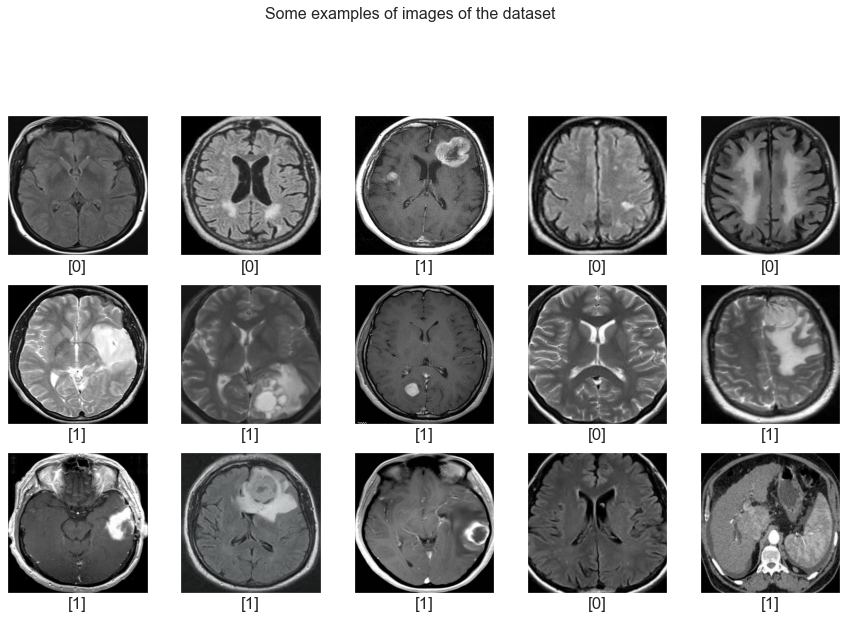

In [14]:
display_examples( X_test, y_test, 15)

### Verifico train

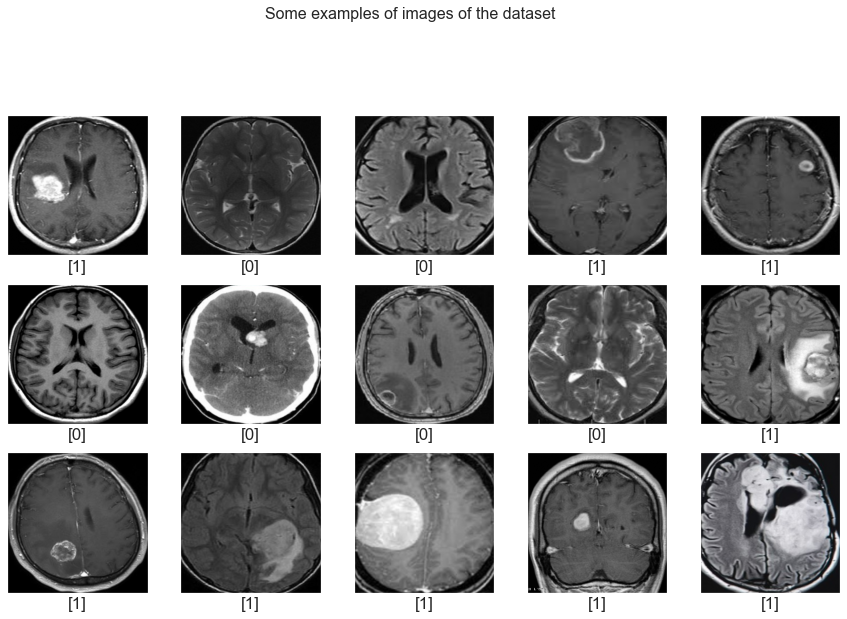

In [15]:
display_examples(X_train, y_train, 15)

<a name="Funcion_callback"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## Declaro función para guardar mejor modelo y earlystoppling

In [9]:
def call_backs(nombre_modelo):
    callbacks = [
                ModelCheckpoint(nombre_modelo, save_best_only=True, verbose = 0),
                EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    ]
    return callbacks

<a name="VGG16"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## Modelo CNN VGG16

In [33]:
base_model = VGG16(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  ) 

for layer in base_model.layers:
    layer.trainable = False

##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)


# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

modelVGG16 = tf.keras.models.Model(base_model.input, x)

modelVGG16.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [34]:
vgghist16 = modelVGG16.fit(X_train,
                            y_train,
                            callbacks = [call_backs(PATH_MODEL + "model_VGG16_v2.h5")],
                            batch_size = BATCH_SIZE,
                            epochs = EPOCHS,
                            validation_split = 0.2,
                            verbose = 1)

Epoch 1/50
37/37 [==============================] - 46s 1s/step - loss: 2.9606 - accuracy: 0.6796 - val_loss: 1.0532 - val_accuracy: 0.6522
Epoch 2/50
37/37 [==============================] - 48s 1s/step - loss: 0.6388 - accuracy: 0.8343 - val_loss: 0.8319 - val_accuracy: 0.7826
Epoch 3/50
37/37 [==============================] - 53s 1s/step - loss: 0.3183 - accuracy: 0.8895 - val_loss: 0.3124 - val_accuracy: 0.9130
Epoch 4/50
37/37 [==============================] - 48s 1s/step - loss: 0.1545 - accuracy: 0.9503 - val_loss: 0.6608 - val_accuracy: 0.7391
Epoch 5/50
37/37 [==============================] - 48s 1s/step - loss: 0.1456 - accuracy: 0.9392 - val_loss: 0.4519 - val_accuracy: 0.8696
Epoch 6/50
37/37 [==============================] - 48s 1s/step - loss: 0.0333 - accuracy: 0.9834 - val_loss: 0.9532 - val_accuracy: 0.7609
Epoch 00006: early stopping


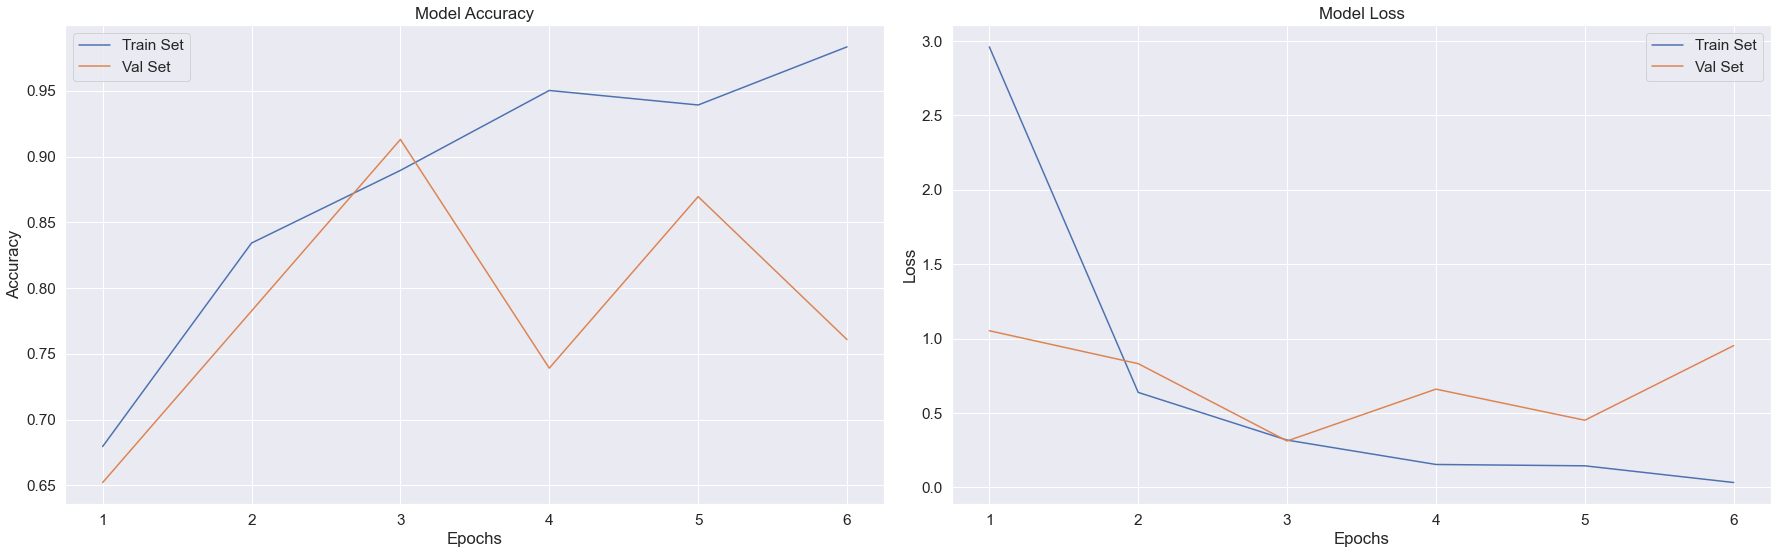

In [35]:
plot_accuracy_loss(vgghist16)

In [36]:
modelVGG16.load_weights(PATH_MODEL + "model_VGG16_v2.h5")
modelVGG16.evaluate(X_test, y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.4392 - accuracy: 0.8077


[0.439179927110672, 0.807692289352417]

### Predicciones VGG16

In [37]:
predictionsVGG16 = modelVGG16.predict(X_test)
predictionsVGG16

array([[6.2866658e-02],
       [7.2969764e-02],
       [9.8687994e-01],
       [9.5929134e-01],
       [9.0338939e-01],
       [7.5706184e-01],
       [3.5380721e-02],
       [9.8133755e-01],
       [1.6147494e-03],
       [9.9950171e-01],
       [9.9999112e-01],
       [9.0579855e-01],
       [9.9889779e-01],
       [2.0399988e-03],
       [9.9968863e-01],
       [4.5511127e-04],
       [9.9314618e-01],
       [5.9287345e-01],
       [9.9348652e-01],
       [1.5309453e-04],
       [7.0007175e-02],
       [3.2851398e-03],
       [2.7388083e-05],
       [7.3636002e-05],
       [9.9165273e-01],
       [3.7301591e-01]], dtype=float32)

In [38]:
predictionsVGG16_rounded = []
for prediction in predictionsVGG16:
    if prediction > 0.5:
        predictionsVGG16_rounded.append(1)
    else:
        predictionsVGG16_rounded.append(0)
predictionsVGG16_rounded = np.array(predictionsVGG16_rounded) 
predictionsVGG16_rounded

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0])

### Errores en VGG16

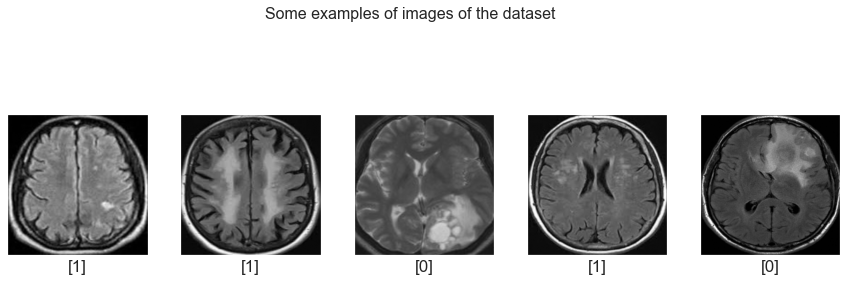

In [39]:
print_mislabeled_images( X_test, y_test, predictionsVGG16_rounded, 5)

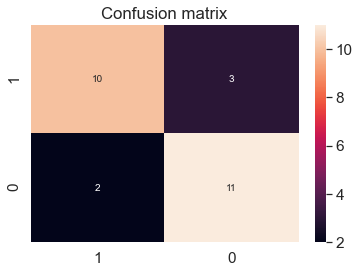

In [51]:
CM = confusion_matrix(y_test, predictionsVGG16_rounded)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

<a name="Inception_V3"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## Modelo CNN InceptionV3

In [10]:
base_model = InceptionV3(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  )

for layer in base_model.layers:
    layer.trainable = False
    
x = layers.Flatten()(base_model.output)
x = layers.Dense(2048, activation = 'relu')(x)
x = layers.Dense(2048, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

modelV3 = tf.keras.models.Model(base_model.input, x)

modelV3.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [11]:
modelV3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [41]:
histincV3 = modelV3.fit(X_train,
                        y_train,
                        callbacks = [call_backs(PATH_MODEL + "model_InceptionV3.h5")],
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        validation_split = 0.2,
                        verbose = 1)

Epoch 1/50
37/37 [==============================] - 92s 2s/step - loss: 44.8931 - accuracy: 0.6409 - val_loss: 3.0294 - val_accuracy: 0.5870
Epoch 2/50
37/37 [==============================] - 92s 2s/step - loss: 3.6443 - accuracy: 0.7127 - val_loss: 0.7815 - val_accuracy: 0.8696
Epoch 3/50
37/37 [==============================] - 85s 2s/step - loss: 1.2189 - accuracy: 0.8453 - val_loss: 0.6305 - val_accuracy: 0.8043
Epoch 4/50
37/37 [==============================] - 83s 2s/step - loss: 0.3346 - accuracy: 0.9282 - val_loss: 0.8556 - val_accuracy: 0.8261
Epoch 5/50
37/37 [==============================] - 79s 2s/step - loss: 2.3376 - accuracy: 0.8619 - val_loss: 25.2024 - val_accuracy: 0.5435
Epoch 6/50
37/37 [==============================] - 76s 2s/step - loss: 1.0754 - accuracy: 0.9282 - val_loss: 1.6300 - val_accuracy: 0.8478
Epoch 00006: early stopping


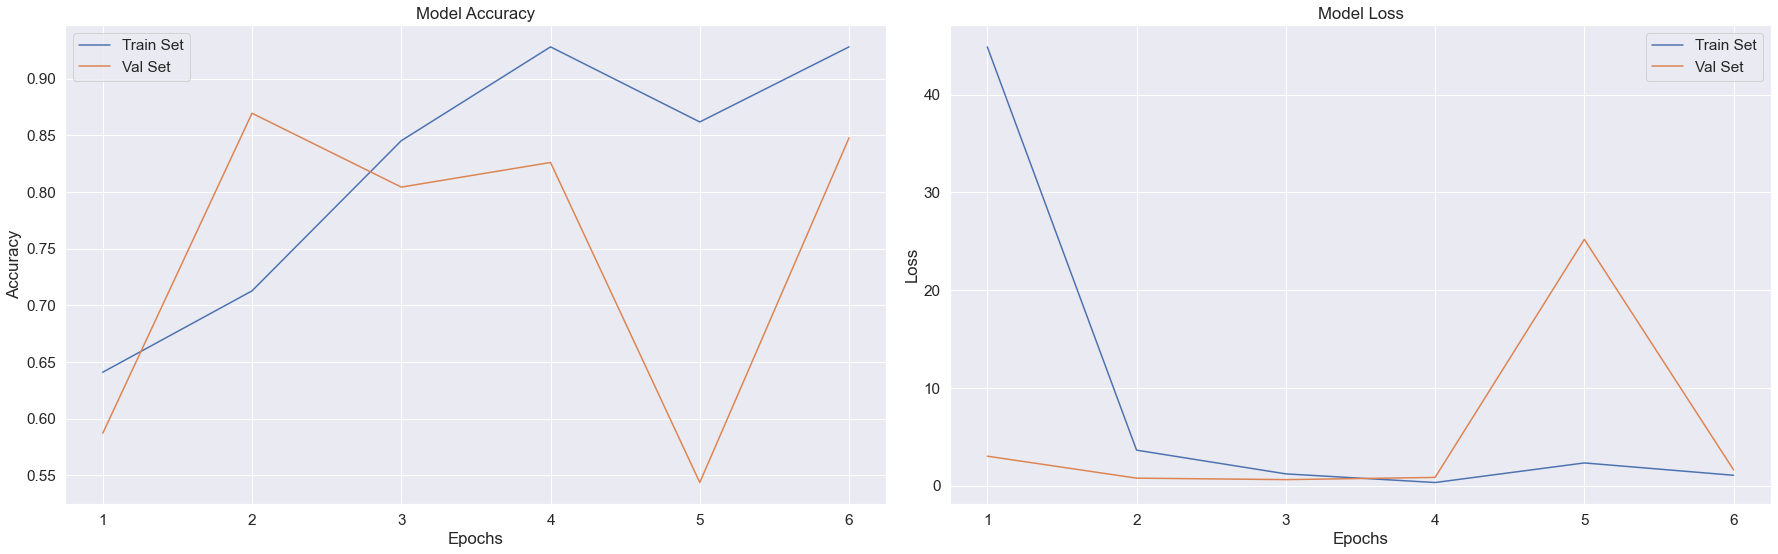

In [42]:
plot_accuracy_loss(histincV3)

In [43]:
modelV3.load_weights(PATH_MODEL + "model_InceptionV3.h5")
modelV3.evaluate(X_test,y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.9909 - accuracy: 0.8462


[0.9908753037452698, 0.8461538553237915]

### Predicciones InceptionV3

In [44]:
predictionsV3 = modelV3.predict(X_test)
predictionsV3

array([[1.4277965e-01],
       [6.5660477e-03],
       [1.0000000e+00],
       [9.8125768e-01],
       [9.0312731e-01],
       [9.9989820e-01],
       [9.9946171e-01],
       [9.9999797e-01],
       [7.7557862e-02],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9996501e-01],
       [1.0000000e+00],
       [1.2147129e-03],
       [1.0000000e+00],
       [2.3362041e-04],
       [9.9999982e-01],
       [6.5729052e-02],
       [9.9997658e-01],
       [9.9997568e-01],
       [9.9962735e-01],
       [4.5443705e-01],
       [1.1832207e-02],
       [2.3393631e-03],
       [9.9998736e-01],
       [9.9999976e-01]], dtype=float32)

In [45]:
predictionsV3_rounded = []
for prediction in predictionsV3:
    if prediction > 0.5:
        predictionsV3_rounded.append(1)
    else:
        predictionsV3_rounded.append(0)
predictionsV3_rounded = np.array(predictionsV3_rounded) 
predictionsV3_rounded

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1])

### Errores en V3

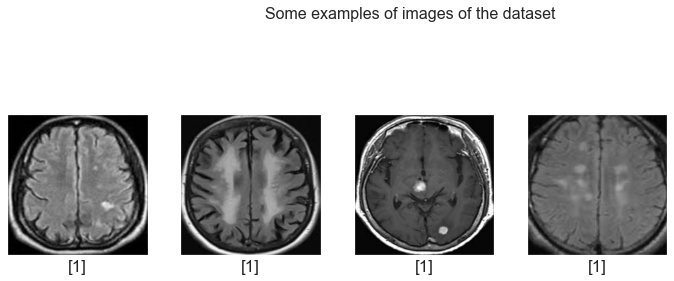

In [47]:
print_mislabeled_images( X_test, y_test, predictionsV3_rounded, 4)

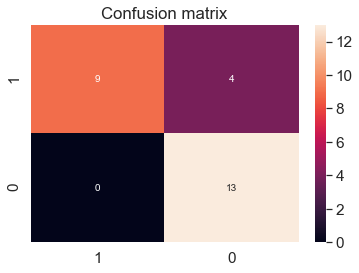

In [52]:
CM = confusion_matrix(y_test, predictionsV3_rounded)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

<a name="VGG19"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## Modelo CNN VGG19

In [13]:
base_model = VGG19(input_shape = (IMG_SIZE,IMG_SIZE,3),
                  include_top = False,
                  weights = 'imagenet'  #None para entrenarla de cero sin quedarte la parte convolucionada preentrenada
                  ) 

for layer in base_model.layers:
    layer.trainable = False

##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(2024, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

modelVGG19 = tf.keras.models.Model(base_model.input, x)

modelVGG19.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [14]:
modelVGG19.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0   

In [54]:
vgghist19 = modelVGG19.fit(X_train,
                            y_train,
                            callbacks = [call_backs(PATH_MODEL + "model_VGG19_v2.h5")],
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_split = 0.2,
                            verbose = 1)

Epoch 1/50
37/37 [==============================] - 50s 1s/step - loss: 5.1601 - accuracy: 0.5746 - val_loss: 0.7039 - val_accuracy: 0.7609
Epoch 2/50
37/37 [==============================] - 57s 2s/step - loss: 0.4347 - accuracy: 0.8453 - val_loss: 0.5592 - val_accuracy: 0.7826
Epoch 3/50
37/37 [==============================] - 51s 1s/step - loss: 0.5045 - accuracy: 0.8122 - val_loss: 0.5249 - val_accuracy: 0.7609
Epoch 4/50
37/37 [==============================] - 50s 1s/step - loss: 0.3828 - accuracy: 0.8950 - val_loss: 0.4035 - val_accuracy: 0.8478
Epoch 5/50
37/37 [==============================] - 48s 1s/step - loss: 0.2617 - accuracy: 0.8895 - val_loss: 0.5510 - val_accuracy: 0.7391
Epoch 6/50
37/37 [==============================] - 48s 1s/step - loss: 0.1530 - accuracy: 0.9171 - val_loss: 0.5543 - val_accuracy: 0.7826
Epoch 7/50
37/37 [==============================] - 49s 1s/step - loss: 0.0698 - accuracy: 0.9669 - val_loss: 0.3955 - val_accuracy: 0.8478
Epoch 8/50
37/37 [==

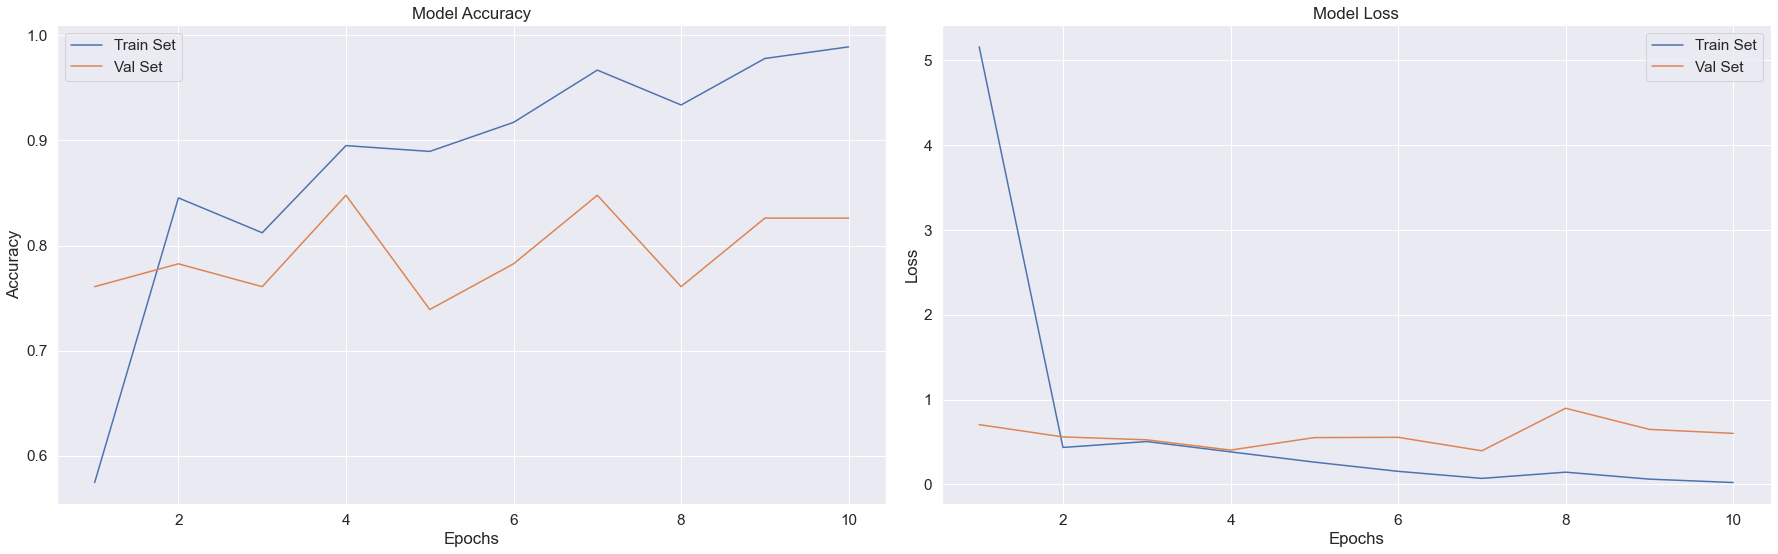

In [55]:
plot_accuracy_loss(vgghist19)

In [56]:
modelVGG19.load_weights(PATH_MODEL + "model_VGG19_v2.h5")
modelVGG19.evaluate(X_test, y_test)

1/1 [==============================] - 5s 5s/step - loss: 0.4728 - accuracy: 0.8462


[0.47276756167411804, 0.8461538553237915]

### Predicciones de VGG19

In [57]:
predictionsmodelVGG19 = modelVGG19.predict(X_test)
predictionsmodelVGG19

array([[6.3734949e-03],
       [5.7053566e-03],
       [9.9715477e-01],
       [5.0867593e-01],
       [3.3624077e-01],
       [6.7141771e-02],
       [3.2629848e-02],
       [9.7490108e-01],
       [1.4438033e-03],
       [9.9297655e-01],
       [9.9998164e-01],
       [6.4068353e-01],
       [9.9950564e-01],
       [2.4873018e-04],
       [9.9998152e-01],
       [1.6883016e-04],
       [9.8787999e-01],
       [4.2703360e-02],
       [9.3069184e-01],
       [1.0449405e-05],
       [1.1821389e-03],
       [7.0345998e-03],
       [6.4248547e-06],
       [2.7852380e-05],
       [8.9848197e-01],
       [1.3434231e-02]], dtype=float32)

In [58]:
predictionsVGG19_rounded = []
for prediction in predictionsmodelVGG19:
    if prediction > 0.5:
        predictionsVGG19_rounded.append(1)
    else:
        predictionsVGG19_rounded.append(0)
predictionsVGG19_rounded = np.array(predictionsVGG19_rounded) 
predictionsVGG19_rounded

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0])

### Errores en VGG19

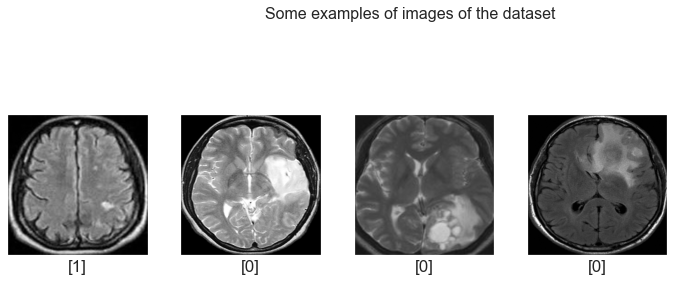

In [60]:
print_mislabeled_images( X_test, y_test, predictionsVGG19_rounded, 4)

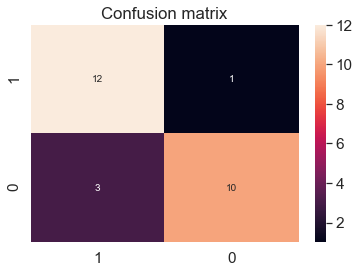

In [61]:
CM = confusion_matrix(y_test, predictionsVGG19_rounded)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

<a name="Comparativa_pred"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### Comparativa predicciones

In [62]:
print('VGG16: ',predictionsVGG16_rounded )
print('IV:    ', predictionsV3_rounded)
print('VGG19: ', predictionsVGG19_rounded )

VGG16:  [0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0]
IV:     [0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1]
VGG19:  [0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0]


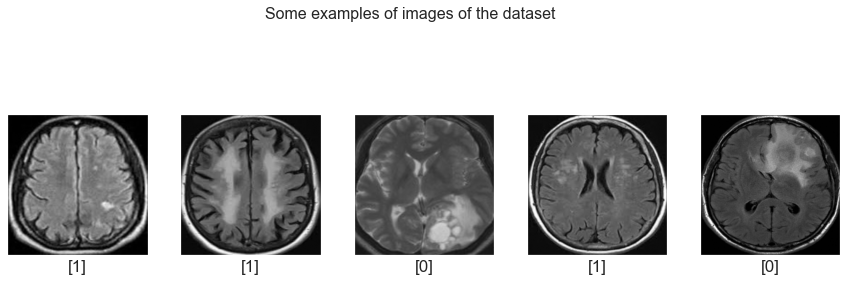

In [65]:
print_mislabeled_images( X_test, y_test, predictionsVGG16_rounded, 5)

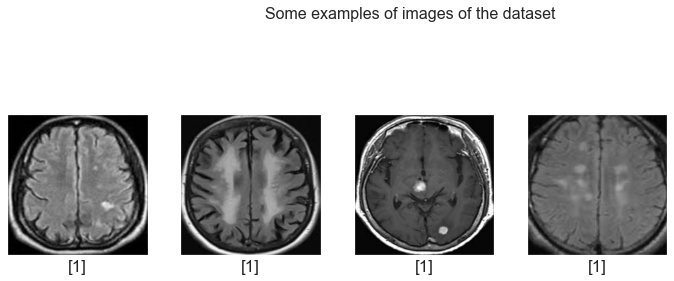

In [66]:
print_mislabeled_images( X_test, y_test, predictionsV3_rounded, 4)

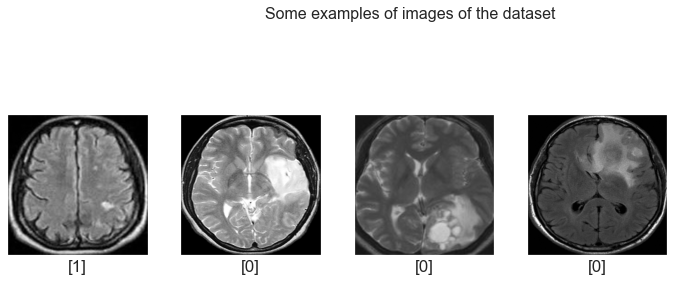

In [67]:
print_mislabeled_images( X_test, y_test, predictionsVGG19_rounded, 4)